In [116]:
from convokit import Corpus, download, HyperConvo
import pandas as pd
import numpy as np
from collections import Counter
from scipy import stats
import json
from datetime import datetime
import pickle as pk

In [179]:
from nltk import word_tokenize 
from nltk.util import ngrams
from collections import Counter

In [181]:
import collections.abc
collections.Hashable = collections.abc.Hashable
from numpy_ml import ngram

In [451]:
import scipy.stats as stats

SUBREDDITS = ['Buddhism', 'Christianity', 'TrueChristian', 'Judaism', 'exchristian', 'Catholicism']

def calc_conf_interval(data):
    interval = stats.norm.interval(confidence=0.95, loc=np.mean(data), scale=stats.sem(data))
    return (interval[-1] - interval[0])/2

In [256]:
# def preprocess(corpus):
#     for utt in corpus.iter_utterances():
#         datetime_obj = datetime.fromtimestamp(utt.timestamp)
#         utt.add_meta("year", datetime_obj.year)
#         utt.add_meta("month", datetime_obj.month)
#         utt.add_meta("day", datetime_obj.day)
#         utt.add_meta("moreThanFiveWords", len(utt.text.split()) > 5)
#     return corpus

In [258]:
# for subreddit in [
# #     'exchristian', 
# #     'RadicalChristianity', 
#     'Catholicism'
# ]:
#     corpus = Corpus(filename=download(f'subreddit-{subreddit}'), storage_type='db')
#     corpus = preprocess(corpus)
#     df = corpus.get_utterances_dataframe(selector = lambda utt: len(utt.text.split()) > 5)
#     df = df[df['speaker'] != "[deleted]"]
#     df['year-month'] = df['meta.year'].astype(str) + "-" + df['meta.month'].astype(str).str.zfill(2)
#     dfs[subreddit] = df

Dataset already exists at /Users/wyw/.convokit/downloads/subreddit-Catholicism


## Prepare dataset

In [11]:
from convokit import Corpus, download, HyperConvo
import pandas as pd
import numpy as np
from collections import Counter
from scipy import stats
import json
from datetime import datetime
import pickle as pk
import matplotlib.pyplot as plt

In [17]:
dfs = dict()
for subreddit in SUBREDDITS:
    corpus = Corpus.reconnect_to_db(f'subreddit-{subreddit}')
    df = corpus.get_utterances_dataframe(selector = lambda utt: len(utt.text.split()) > 5)
    df = df[df['speaker'] != "[deleted]"]
    df['year-month'] = df['meta.year'].astype(str) + "-" + df['meta.month'].astype(str).str.zfill(2)
    dfs[subreddit] = df
    

In [53]:
newcomer_ratio = dict()

for subreddit in SUBREDDITS:
    df = dfs[subreddit]
    first_post = df.groupby(['speaker'])['year-month'].min()
    first_post = first_post.reset_index()
    utts_by_year = df.groupby('year-month').size()
    spks_by_year = df.groupby(['year-month'])['speaker'].nunique()
    # number of newcomer in each year
    s = pd.concat([first_post.groupby('year-month').size(), utts_by_year, spks_by_year], axis=1)
    s = s.rename({0: "newcomer", 1: "utterances"}, axis=1)
    s['oldmembers'] = s['speaker'] - s['newcomer']
    s['newcomer / speaker'] = 100 * (s['newcomer'] / s['speaker'])
    s.columns = pd.MultiIndex.from_product([[subreddit], s.columns])
    newcomer_ratio[subreddit] = s
    

In [60]:
# import pickle as pk
# pk.dump(dfs, open("utts.pk", "wb"))

In [61]:
df.head()

,timestamp,text,speaker,reply_to,conversation_id,meta.author_flair_text,meta.gilded,meta.gildings,meta.permalink,meta.retrieved_on,meta.score,meta.stickied,meta.subreddit,meta.top_level_comment,meta.year,meta.month,meta.day,meta.moreThanFiveWords,vectors,year-month
id,,,,,,,,,,,,,,,,,,,,
cl2lw,1278016773,"""We are susceptible to heretical teachings bec...",Tiomaidh,None,cl2lw,Anglican Communion,0,None,/r/Christianity/comments/cl2lw/i_saw_this_quot...,1522932221,14,False,Christianity,None,2010,7,1,True,[],2010-07
cl4fg,1278027744,Let's keep him in our [prayers](http://www.bib...,nopaniers,None,cl4fg,,0,None,/r/Christianity/comments/cl4fg/christopher_hit...,1522932259,9,False,Christianity,None,2010,7,1,True,[],2010-07
clfza,1278105148,http://www.reddit.com/r/reddit.com/comments/cl...,chemistry_teacher,None,clfza,,0,None,/r/Christianity/comments/clfza/for_once_christ...,1522932493,0,False,Christianity,None,2010,7,2,True,[],2010-07
clfze,1278105158,http://www.reddit.com/r/reddit.com/comments/cl...,chemistry_teacher,None,clfze,,0,None,/r/Christianity/comments/clfze/for_once_christ...,1522932493,0,False,Christianity,None,2010,7,2,True,[],2010-07
clg0l,1278105416,http://www.reddit.com/r/reddit.com/comments/cl...,chemistry_teacher,None,clg0l,,0,None,/r/Christianity/comments/clg0l/for_once_christ...,1522932495,0,False,Christianity,None,2010,7,2,True,[],2010-07


In [260]:
comments = dict()x
for subreddit in SUBREDDITS:
    df = dfs[subreddit]
    comments[subreddit] = df[df['reply_to'].notnull()].copy()

In [264]:
# pk.dump(comments, open("comments.pk", "wb"))

In [261]:
speaker_comments_stats = dict()
for subreddit in SUBREDDITS:
    speaker_comments_by_month = comments[subreddit].groupby(['speaker', 'year-month']).size().reset_index(name="n_comments_this_month")
    speaker_comments_by_month['cum_comments'] = speaker_comments_by_month.groupby(['speaker'])['n_comments_this_month'].cumsum(axis=0)
    speaker_comments_by_month['n_comments_before_month'] = speaker_comments_by_month['cum_comments'] - speaker_comments_by_month['n_comments_this_month']
    speaker_comments_stats[subreddit] = speaker_comments_by_month

In [263]:
MONTHS = [
    '2016-01',
 '2016-02',
 '2016-03',
 '2016-04',
 '2016-05',
 '2016-06',
 '2016-07',
 '2016-08',
 '2016-09',
 '2016-10',
 '2016-11',
 '2016-12',
 '2017-01',
 '2017-02',
 '2017-03',
 '2017-04',
 '2017-05',
 '2017-06',
 '2017-07',
 '2017-08',
 '2017-09',
 '2017-10',
 '2017-11',
 '2017-12',
 '2018-01',
 '2018-02',
 '2018-03',
 '2018-04',
 '2018-05',
 '2018-06',
 '2018-07',
 '2018-08',
 '2018-09',
 '2018-10'
]

In [287]:
selected_ref_speakers = valid_ref_speakers
selected_spk_comments_df = comments_df[
    (comments_df['speaker'].isin(selected_ref_speakers)) & 
    (comments_df['year-month'] == year_month)
                                      ]
selected_spk_comments_df.groupby('speaker').apply(lambda x: x.sample(2)).reset_index(drop=True)['id']

0       e78jw1u
1       e8q5rxh
2       e83twsw
3       e8kkoaq
4       e7mu4c1
         ...   
1673    e7rseyg
1674    e7pr81m
1675    e8mc5nb
1676    e7jy82f
1677    e8q9nzw
Name: id, Length: 1678, dtype: object

In [294]:
ref_comments_df = selected_spk_comments_df.reset_index().groupby('speaker').apply(
            lambda x: x.sample(n_comments_per_spk)
        )

In [296]:
ref_comments_df.reset_index(drop=True)

,id,speaker,year-month,text
0,cz3shob,-Mochaccina-,2016-01,"Yes, only, on the physical side, because it's ..."
1,czbw38q,-Mochaccina-,2016-01,Every age group is represented at our Parish a...
2,czijxqb,0001u,2016-01,'An influential Italian Catholic leader presen...
3,cz59ic0,0001u,2016-01,Is it really just rumour? Has he not explicitl...
4,cz6ia2r,10113519,2016-01,&gt; It maintains that a foetus is a person wo...
...,...,...,...,...
947,czcp5as,you_know_what_you,2016-01,I hear great things about this Baronius Press ...
948,cz6u421,zero44,2016-01,"I really like the sound of a lot of APC, and i..."
949,cypgbrz,zero44,2016-01,&gt;I also see I need to go to Mass on the Thu...
950,cz792r9,zxo,2016-01,"Yes, this is the section I was thinking of, th..."


In [308]:
speaker_comments_by_month.sort_values("speaker")

,speaker,year-month,n_comments_this_month,cum_comments,n_comments_before_month
0,--3--,2016-05,2,2,0
1,--Francis--,2017-06,1,1,0
2,--RF--,2018-07,3,3,0
3,--RF--,2018-09,1,4,3
4,--Sigma--,2014-04,5,5,0
...,...,...,...,...,...
143266,zyzzvya,2015-09,15,15,0
143267,zzing,2010-11,3,3,0
143268,zzing,2013-09,4,7,3
143269,zzzbleble,2016-08,3,3,0


In [346]:
speaker_comments_by_month.groupby("year-month")['n_comments_before_month'].apply(
    lambda data: np.percentile(data, 80)
).to_dict()

{'2012-05': 0.0,
 '2012-06': 0.0,
 '2012-07': 0.0,
 '2012-08': 1.0,
 '2012-09': 1.8000000000000114,
 '2012-10': 45.00000000000003,
 '2012-11': 39.60000000000001,
 '2012-12': 28.400000000000006,
 '2013-01': 43.2,
 '2013-02': 36.0,
 '2013-03': 19.600000000000023,
 '2013-04': 37.0,
 '2013-05': 46.0,
 '2013-06': 8.0,
 '2013-07': 11.0,
 '2013-08': 13.0,
 '2013-09': 28.0,
 '2013-10': 77.60000000000014,
 '2013-11': 35.400000000000034,
 '2013-12': 39.0,
 '2014-01': 43.0,
 '2014-02': 58.400000000000034,
 '2014-03': 45.0,
 '2014-04': 44.80000000000007,
 '2014-05': 49.60000000000002,
 '2014-06': 55.0,
 '2014-07': 49.60000000000002,
 '2014-08': 53.2000000000001,
 '2014-09': 63.0,
 '2014-10': 40.60000000000002,
 '2014-11': 44.0,
 '2014-12': 43.0,
 '2015-01': 37.0,
 '2015-02': 41.0,
 '2015-03': 38.0,
 '2015-04': 45.0,
 '2015-05': 40.40000000000009,
 '2015-06': 46.200000000000045,
 '2015-07': 52.0,
 '2015-08': 62.200000000000045,
 '2015-09': 63.200000000000045,
 '2015-10': 62.80000000000007,
 '2015-1

<AxesSubplot: xlabel='year-month'>

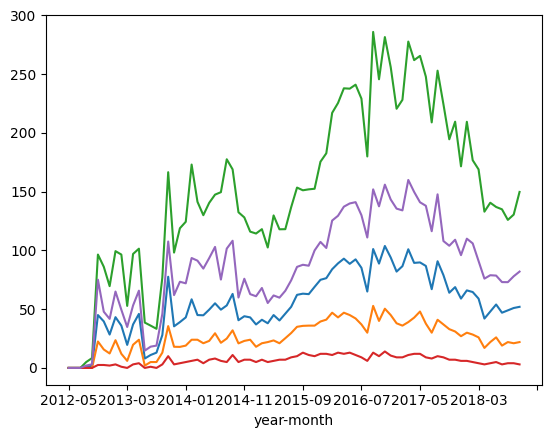

In [339]:
subreddit = 'TrueChristian'
speaker_comments_by_month = speaker_comments_stats[subreddit]
speaker_comments_by_month.groupby("year-month")['n_comments_before_month'].apply(
    lambda data: np.percentile(data, 80)
).plot()
speaker_comments_by_month.groupby("year-month")['n_comments_before_month'].apply(
    lambda data: np.percentile(data, 70)
).plot()
speaker_comments_by_month.groupby("year-month")['n_comments_before_month'].apply(
    lambda data: np.percentile(data, 90)
).plot()
speaker_comments_by_month.groupby("year-month")['n_comments_before_month'].apply(
    lambda data: np.percentile(data, 50)
).plot()
speaker_comments_by_month.groupby("year-month")['n_comments_before_month'].apply(
    lambda data: np.percentile(data, 85)
).plot()

In [311]:
speaker_comments_by_month[speaker_comments_by_month['speaker'] == 'avengingturnip']

,speaker,year-month,n_comments_this_month,cum_comments,n_comments_before_month
76199,avengingturnip,2009-02,1,1,0
76200,avengingturnip,2010-03,3,4,1
76201,avengingturnip,2010-04,3,7,4
76202,avengingturnip,2010-09,15,22,7
76203,avengingturnip,2010-10,9,31,22
...,...,...,...,...,...
76288,avengingturnip,2018-06,32,5766,5734
76289,avengingturnip,2018-07,50,5816,5766
76290,avengingturnip,2018-08,119,5935,5816
76291,avengingturnip,2018-09,39,5974,5935


In [352]:
# for every month after 2016
# ref_comments_idx = dict()
# ref_comments_text = dict()

n_comments_per_spk = 2

for subreddit in [
#     'TrueChristian', 
#     'Buddhism', 
#     'Judaism',
    'Christianity',
#     'exchristian', 
    'RadicalChristianity', 
#     'Catholicism'
]:
    print(subreddit)
    ref_comments_idx[subreddit] = dict()
    ref_comments_text[subreddit] = dict()
    comments_df = comments[subreddit][['speaker', 'year-month', 'text']]
    speaker_comments_by_month = speaker_comments_stats[subreddit]
    activity_index = speaker_comments_by_month.groupby("year-month")['n_comments_before_month'].apply(
    lambda data: np.percentile(data, 80)
    ).to_dict()
    for year_month in MONTHS:
        print(' ', year_month)
        ref_comments_idx[subreddit][year_month] = list()
        ref_comments_text[subreddit][year_month] = list()
        
        valid_ref_speakers = speaker_comments_by_month[
        (speaker_comments_by_month['year-month'] == year_month) &
        (speaker_comments_by_month['n_comments_before_month'] >= activity_index[year_month]) &
        (speaker_comments_by_month['n_comments_this_month'] >= 5) 
                             ]['speaker'].unique()

#         selected_ref_speakers = np.random.choice(valid_ref_speakers, size=n_spk, replace=False)
        selected_ref_speakers = valid_ref_speakers
        selected_spk_comments_df = comments_df[
            (comments_df['speaker'].isin(selected_ref_speakers)) & 
            (comments_df['year-month'] == year_month)
                                              ].reset_index()
        ref_comments_df = selected_spk_comments_df.groupby('speaker').apply(
            lambda x: x.sample(n_comments_per_spk)
        ).reset_index(drop=True)
        ref_comments_idx[subreddit][year_month] += ref_comments_df['id'].values.tolist()
        ref_comments_text[subreddit][year_month] += ref_comments_df['text'].values.tolist()

Christianity
  2016-01
  2016-02
  2016-03
  2016-04
  2016-05
  2016-06
  2016-07
  2016-08
  2016-09
  2016-10
  2016-11
  2016-12
  2017-01
  2017-02
  2017-03
  2017-04
  2017-05
  2017-06
  2017-07
  2017-08
  2017-09
  2017-10
  2017-11
  2017-12
  2018-01
  2018-02
  2018-03
  2018-04
  2018-05
  2018-06
  2018-07
  2018-08
  2018-09
  2018-10
RadicalChristianity
  2016-01
  2016-02
  2016-03
  2016-04
  2016-05
  2016-06
  2016-07
  2016-08
  2016-09
  2016-10
  2016-11
  2016-12
  2017-01
  2017-02
  2017-03
  2017-04
  2017-05
  2017-06
  2017-07
  2017-08
  2017-09
  2017-10
  2017-11
  2017-12
  2018-01
  2018-02
  2018-03
  2018-04
  2018-05
  2018-06
  2018-07
  2018-08
  2018-09
  2018-10


In [355]:
from numpy_ml.preprocessing.nlp import tokenize_words, ngrams, strip_punctuation
N=2 # bi-gram
community_cross_entropy = dict()
newcomer_cross_entropy = dict()

for subreddit in [
    'TrueChristian', 
    'Buddhism', 
    'Judaism',
    'Christianity',
  'exchristian', 
    'RadicalChristianity', 
    'Catholicism'
]:
    print(subreddit)
    comments_df = comments[subreddit][['speaker', 'year-month', 'text']].reset_index()
    speaker_comments_by_month = speaker_comments_stats[subreddit]

    community_cross_entropy[subreddit] = dict()
    newcomer_cross_entropy[subreddit] = dict()

    for year_month in MONTHS:
        print(year_month)

        community_cross_entropy[subreddit][year_month] = list()
        newcomer_cross_entropy[subreddit][year_month] = list()

        ref_filename = f'./ref-{subreddit}-{year_month}.txt'
        with open(ref_filename, mode='wt', encoding='utf-8') as myfile:
            myfile.write('\n'.join(utt.replace("\n", " ") for utt in ref_comments_text[subreddit][year_month]))

        gt = ngram.GoodTuringNGram(N, conf=1.96, unk=True, filter_stopwords=False, filter_punctuation=True)
        gt.train(ref_filename)

        new_speakers = speaker_comments_by_month[
        (speaker_comments_by_month['year-month'] == year_month) & 
        (speaker_comments_by_month['n_comments_before_month'] == 0)
                             ]['speaker'].values.tolist()

        month_comments = comments_df[
            (comments_df['year-month'] == year_month) & 
            (~comments_df['id'].isin(ref_comments_idx[subreddit][year_month]))
                                    ].copy()

        newcomer_comments = month_comments[
            (month_comments['speaker'].isin(new_speakers))                                   
        ].reset_index().to_dict(orient='records')

        community_comments = month_comments[
            (~month_comments['speaker'].isin(new_speakers))                                   
        ].reset_index().to_dict(orient='records')
        
#         balanced_community_comments = np.random.choice(community_comments, size=len(newcomer_comments), replace=False)
#         print(len(community_comments), len(balanced_community_comments), len(newcomer_comments))
        for utt in community_comments:

            line = strip_punctuation(utt['text'])
            words = tokenize_words(line, filter_stopwords=False)
            try:
                cross_entropy = gt.cross_entropy(words, N = N)
            except:
                print('skip: ', utt['id'], utt['text'], words)
            community_cross_entropy[subreddit][year_month].append(cross_entropy)

        for utt in newcomer_comments:

            line = strip_punctuation(utt['text'])
            words = tokenize_words(line, filter_stopwords=False)
            try:
                cross_entropy = gt.cross_entropy(words, N = N)
            except:
                print('skip: ', utt['id'], utt['text'], words)
            newcomer_cross_entropy[subreddit][year_month].append(cross_entropy)


TrueChristian
2016-01
2016-02
2016-03
2016-04
skip:  d2hg76m P R O T E S T A N T

R

O

T

E

S

T

A

N

T []
2016-05
2016-06
skip:  d3uksjk D A Y U M

A

Y

U

M []
skip:  d4k5rk0 /r/Protestantism ( ͡° ͜ʖ ͡°) 

:p ['rprotestantism']
2016-07
2016-08
2016-09
skip:  d7te73j ̿̿ ̿̿ ̿̿ ̿'̿'\̵͇̿̿\з= ( ▀ ͜͞ʖ▀) =ε/̵͇̿̿/’̿’̿ ̿ ̿̿ ̿̿ ̿̿ []
skip:  d7vj1pj E  D  G  Y

D       

G       

Y G D E []
2016-10
2016-11
2016-12
2017-01
skip:  dc6e359 S W I T C H F O O T  
W   
I  
T  
C  
H  
F  
O  
O  
T  
 []
2017-02
2017-03
2017-04
2017-05
2017-06
skip:  djjpvgx T R I G G E R R E D []
2017-07
2017-08
2017-09
skip:  dmvll2j             A B C D D C B A  
          / B           / B  
        /   C         /   C  
      /     D       /     D  
    A B C D D C B A       D  
    B       C     B       C  
    C       B     C       B  
    D       A B C D D C B A  
    D     /       D     /    
    C   /         C   /      
    B /           B /        
    A B C D D C B A          
                      

skip:  dixwnfs             I J I I J I I I  
          / J           / J  
        /   I         /   I  
      /     I       /     I  
    I J I I J I I I       J  
    J       I     J       I  
    I       I     I       I  
    I       I J I I J I I I  
    J     /       J     /    
    I   /         I   /      
    I /           I /        
    I J I I J I I I          
                             
 []
skip:  diyv3s8 W

O

O

L

A

N

D

L

I

N

E

N []
skip:  dj4ju6p ^ ^^ ^^^ ^^^^ ^^^ ^^ ^ []
skip:  dj5usw7 J U S T
U
S
T []
skip:  dj7kri5 ... h e r o i n G []
2017-07
skip:  djy19na M O R A L B A R O M E T E R []
skip:  djyn1ae M O R E L S   N E E D   N O   B A R O M E T E R S []
skip:  dk1vihq *//a  e  t  h e  i s  m//* []
skip:  dk7r0o2 T  U  L  I  P

U

L

I

P []
2017-08
skip:  dl7zrrc D E M I U R G E []
skip:  dle0e0y R E V E L A T I O N []
skip:  dllel93 &gt;WhiteNationalist_Jew

W   E   W   L    A   D

E

W

L

A

D ['gtwhitenationalistjew']
skip:  dlo05ri h y p e r l a t r 

2017-11
skip:  dp8giob THOMAS B E C C E T T  ['thomas']
skip:  dp9qq0c R O M A N   C A T H O L I C I S M

/s []
skip:  dpd2jx6 F A L S E 

E Q U I V A L E N C E  []
skip:  dqgl4h3 T, U, L, I and P. ['and']
skip:  dqbtpm1 S W E D E N Y E S []
2017-12
skip:  dqlublu A L L E G E D []
skip:  dr3k6hb [B E G O M E O R D O D O X](https://steamuserimages-a.akamaihd.net/ugc/860606415969619449/B2DB5C5671F0A3036C55A7FA0A93031C517F9240/?interpolation=lanczos-none&amp;output-format=jpeg&amp;output-quality=95&amp;fit=inside%7C637%3A358&amp;composite-to=*,*%7C637%3A358&amp;background-color=black) ['xhttpssteamuserimagesaakamaihdnetugc860606415969619449b2db5c5671f0a3036c55a7fa0a93031c517f9240interpolationlanczosnoneampoutputformatjpegampoutputquality95ampfitinside7c6373a358ampcompositeto7c6373a358ampbackgroundcolorblack']
skip:  drfkiel L M F A O

COWARDS ['cowards']
skip:  drq3ej2 W E L C H' S.  G R A P E. J U I C E  []
2018-01
skip:  dtbkk7y B O T H S I D E S []
2018-02
skip:  du0rx3m N O T

W I T H

2017-06
skip:  did37am #E D G Y

#D

#G

#Y []
skip:  disw237 #c o m p l e t e 

#t h e o c r a c y []
2017-07
skip:  djrl6ck H O S T H E T I C []
skip:  djryk9a C A T H O L I C M E M E []
skip:  djvl91j Wellllllllll. . . . . .  ? ['wellllllllll']
2017-08
skip:  dlonbvp M I R A C U L O U S M E D A L
I
R
A
C
U
L
O
U
S
M
E
D
A
L []
skip:  dlu0q1x A E S T H E T I C []
skip:  dlzdn5k D I D  Y O U  J U S T  A S S U M E T H E G E N D E R []
2017-09
skip:  dmphza8 \#M U R I C A []
skip:  dmr9jnj 0 - 5 - 2 - 8 - 8 []
skip:  dmxa35n  L A I C I Z E []
skip:  dnlzsn2 R I G I D  
I  
G  
I  
D   []
2017-10
skip:  doyw69w H E R E S Y  D E T E C T E D []
skip:  dp4ta8y A G R E E D []
2017-11
skip:  dp7b344 T o o

s o o n []
skip:  dqbdw5k S O  B R A V E 
O
B
R
A
B
E []
2017-12
skip:  dqx3cxb A V E   M A R I A 

G R A T I A   P L E N A []
skip:  dqxrgiy B E G O N E  P R O T []
skip:  dqxvh2i S C H I S M A T I C S  []
skip:  dr5k422 A S C E T I C I S M []
skip:  dr5n9us A S C E T IC ['ic']
skip:  dr6h

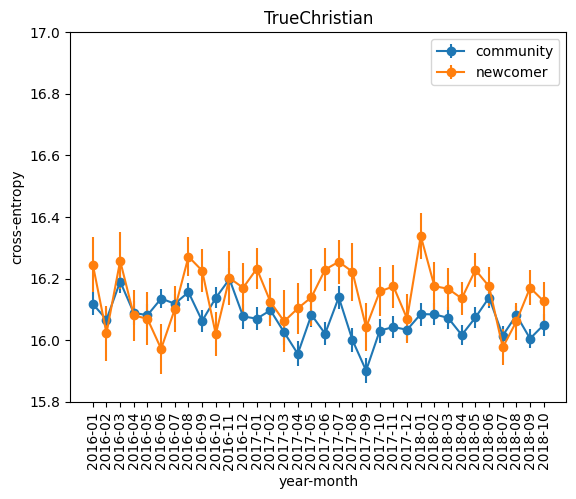

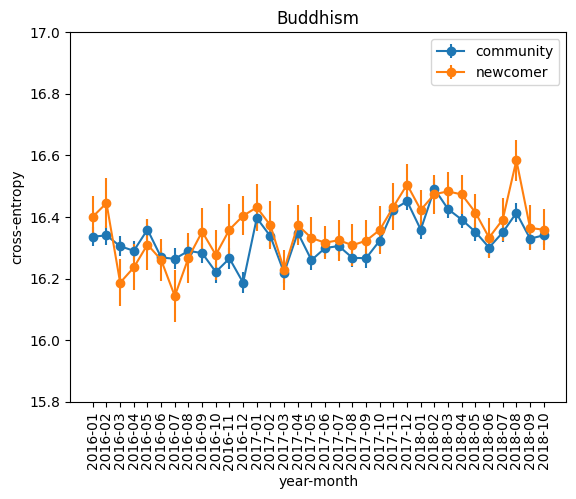

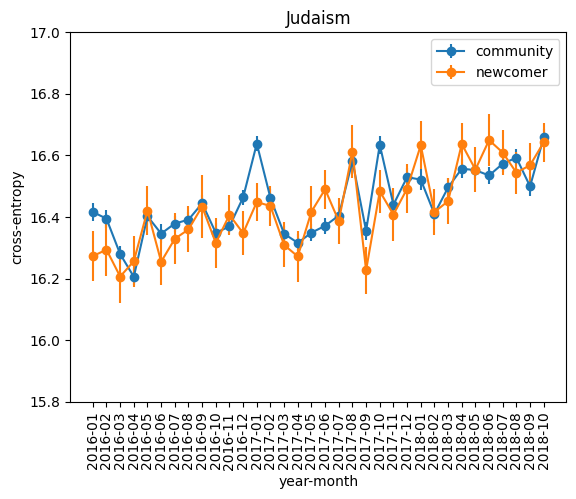

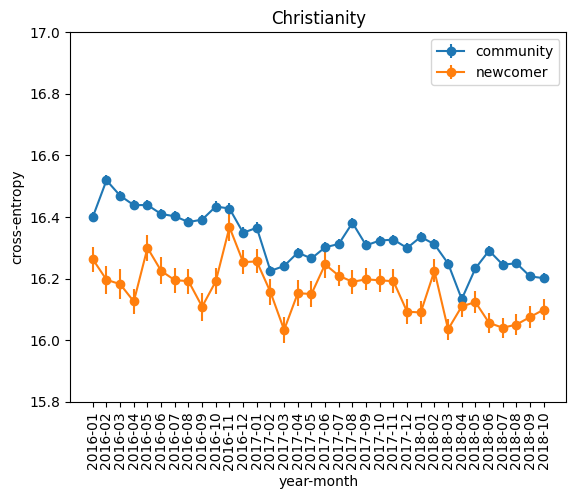

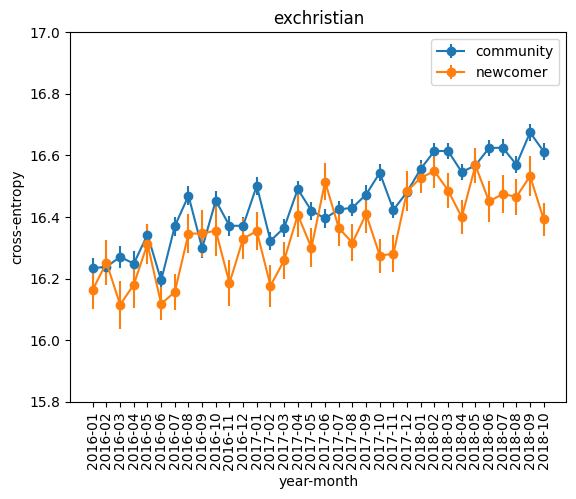

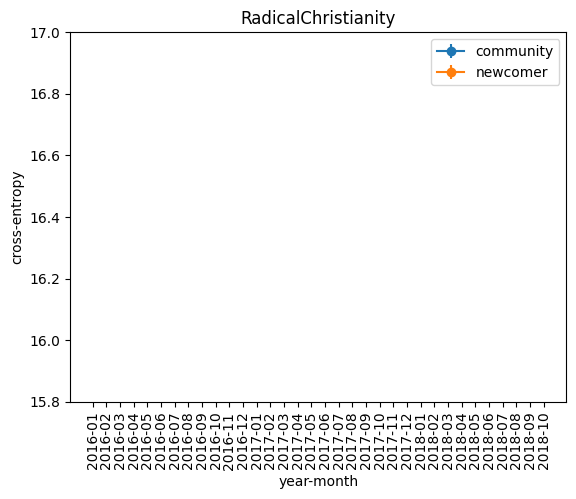

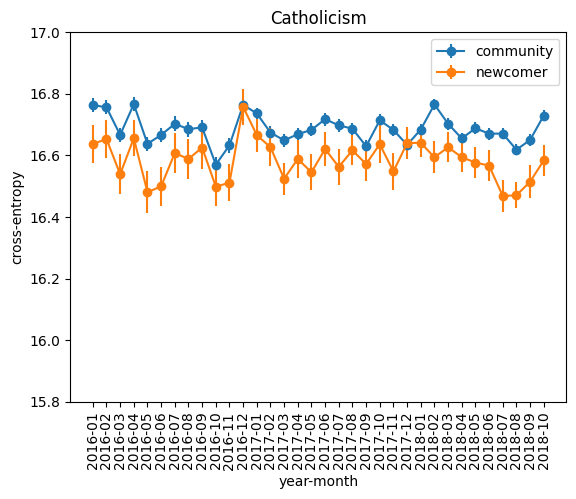

In [357]:
for subreddit in [
    'TrueChristian', 
    'Buddhism', 
    'Judaism',
    'Christianity',
    'exchristian', 
    'RadicalChristianity', 
    'Catholicism'
]:
    mean = [np.mean(community_cross_entropy[subreddit][month]) for month in MONTHS]
    conf_interval = [calc_conf_interval(community_cross_entropy[subreddit][month]) for month in MONTHS]

    plt.errorbar(MONTHS, mean, yerr=conf_interval, fmt="o-", label='community')

    mean = [np.mean(newcomer_cross_entropy[subreddit][month]) for month in MONTHS]
    conf_interval = [calc_conf_interval(newcomer_cross_entropy[subreddit][month]) for month in MONTHS]

    plt.errorbar(MONTHS, mean, yerr=conf_interval, fmt="o-", label='newcomer')
    plt.xticks(rotation=90)
    plt.legend()
    plt.title(subreddit)
    plt.xlabel("year-month")
    plt.ylabel("cross-entropy")
    plt.ylim([15.8, 17])
    plt.show()

## Speaker Longitudinal Changes

### Length of comments

Christianity
exchristian
Catholicism


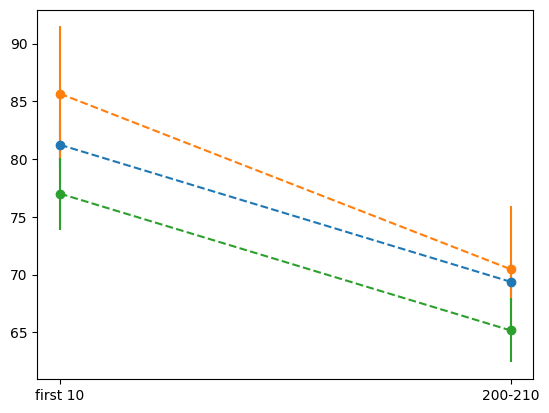

In [433]:
for subreddit in SUBREDDITS:
    print(subreddit)
    df = comments[subreddit]
    group = df.sort_values(['speaker', 'timestamp']).groupby(["speaker"])
    df['order'] = group.cumcount() + 1
    df['text_len'] = df['text'].apply(lambda utt: len(utt.split()))
    speaker_total_comments = df.groupby("speaker")['order'].max().reset_index(name="n_comments")
    speakers = speaker_total_comments[speaker_total_comments['n_comments'] >= 110]['speaker'].values
    # 0 - 10
    early = df[(df['speaker'].isin(speakers)) & (df['order'] <= 10)].groupby('speaker')['text_len']
    early_mean = early.mean()
    # 200 - 210
    late = df[(df['speaker'].isin(speakers)) & (df['order'] < 210) & (df['order'] >= 200)].groupby('speaker')['text_len']
    late_mean = late.mean()

    length_compare = early_mean.reset_index(name="0-10").merge(late_mean.reset_index(name="200-210"))
    length_compare['change'] = length_compare['200-210'] - length_compare['0-10']
    plt.errorbar(['first 10', '200-210'], 
             [length_compare['0-10'].mean(), 
                length_compare['200-210'].mean()], 
            yerr = [calc_conf_interval(length_compare['0-10']), calc_conf_interval(length_compare['200-210'])],
            fmt="o--",
            label=subreddit)

    
plt.legend()
plt.ylabel("mean length")
plt.xlabel("order of comments")
plt.show()


### FightingWords

Buddhism
Initializing default CountVectorizer with ngram_range (1, 1)... Done.
class1_func returned 4650 valid corpus components. class2_func returned 4650 valid corpus components.
Vocab size is 4357
Comparing language...
ngram zscores computed.


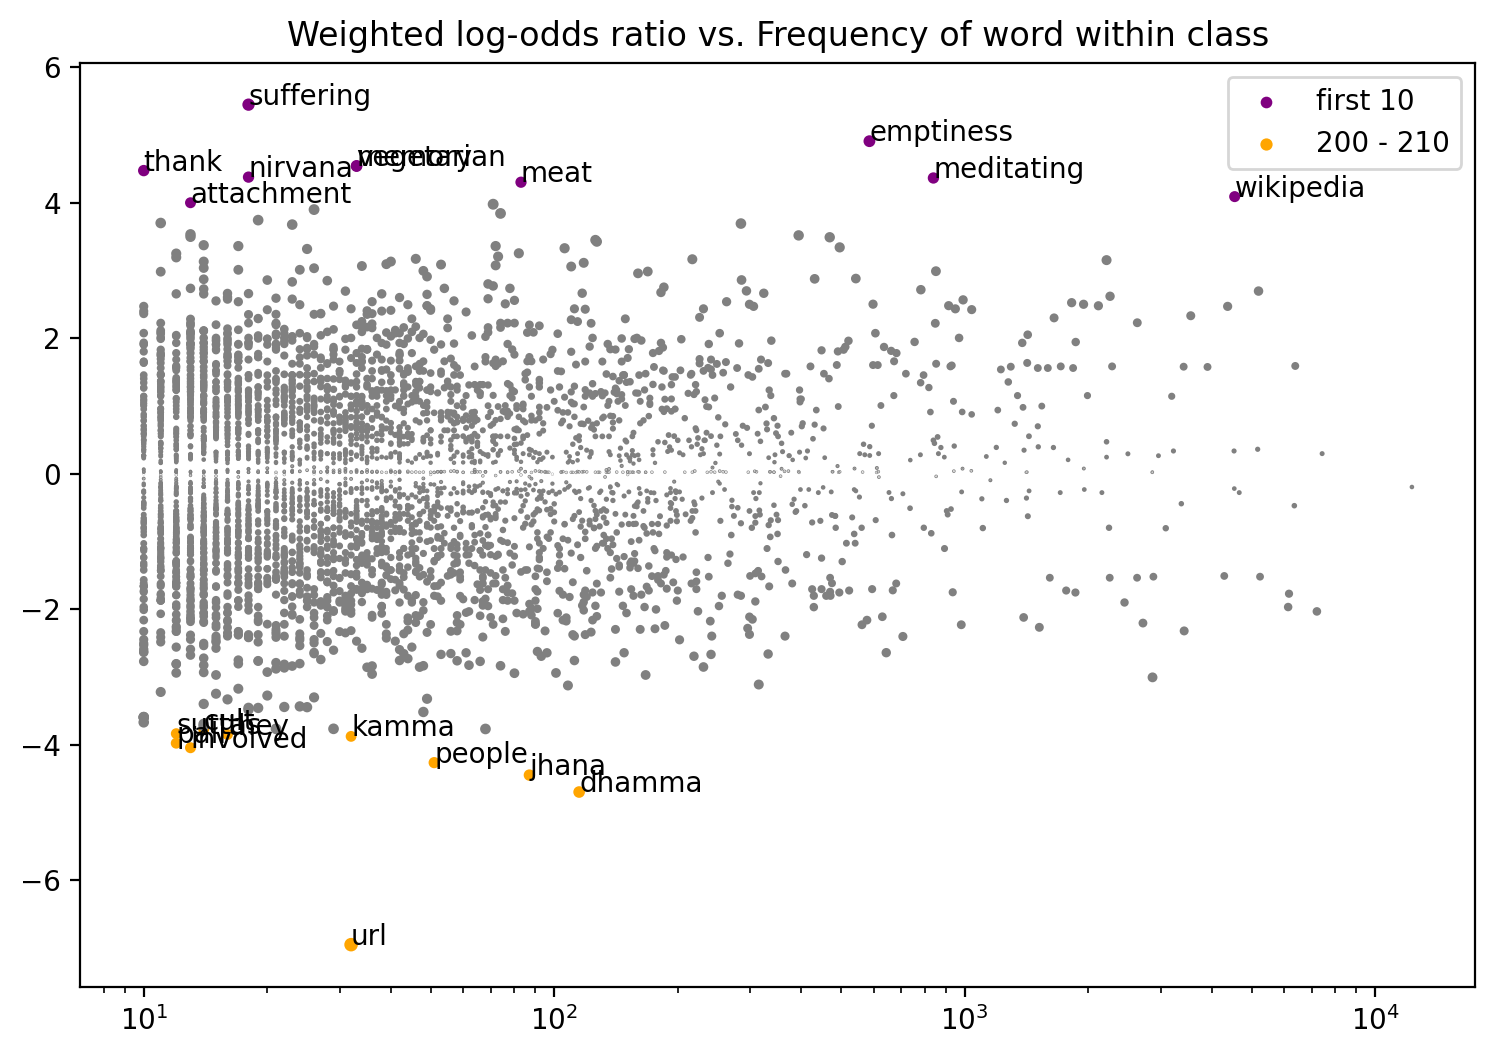

Christianity
Initializing default CountVectorizer with ngram_range (1, 1)... Done.
class1_func returned 36470 valid corpus components. class2_func returned 36470 valid corpus components.
Vocab size is 13162
Comparing language...
ngram zscores computed.


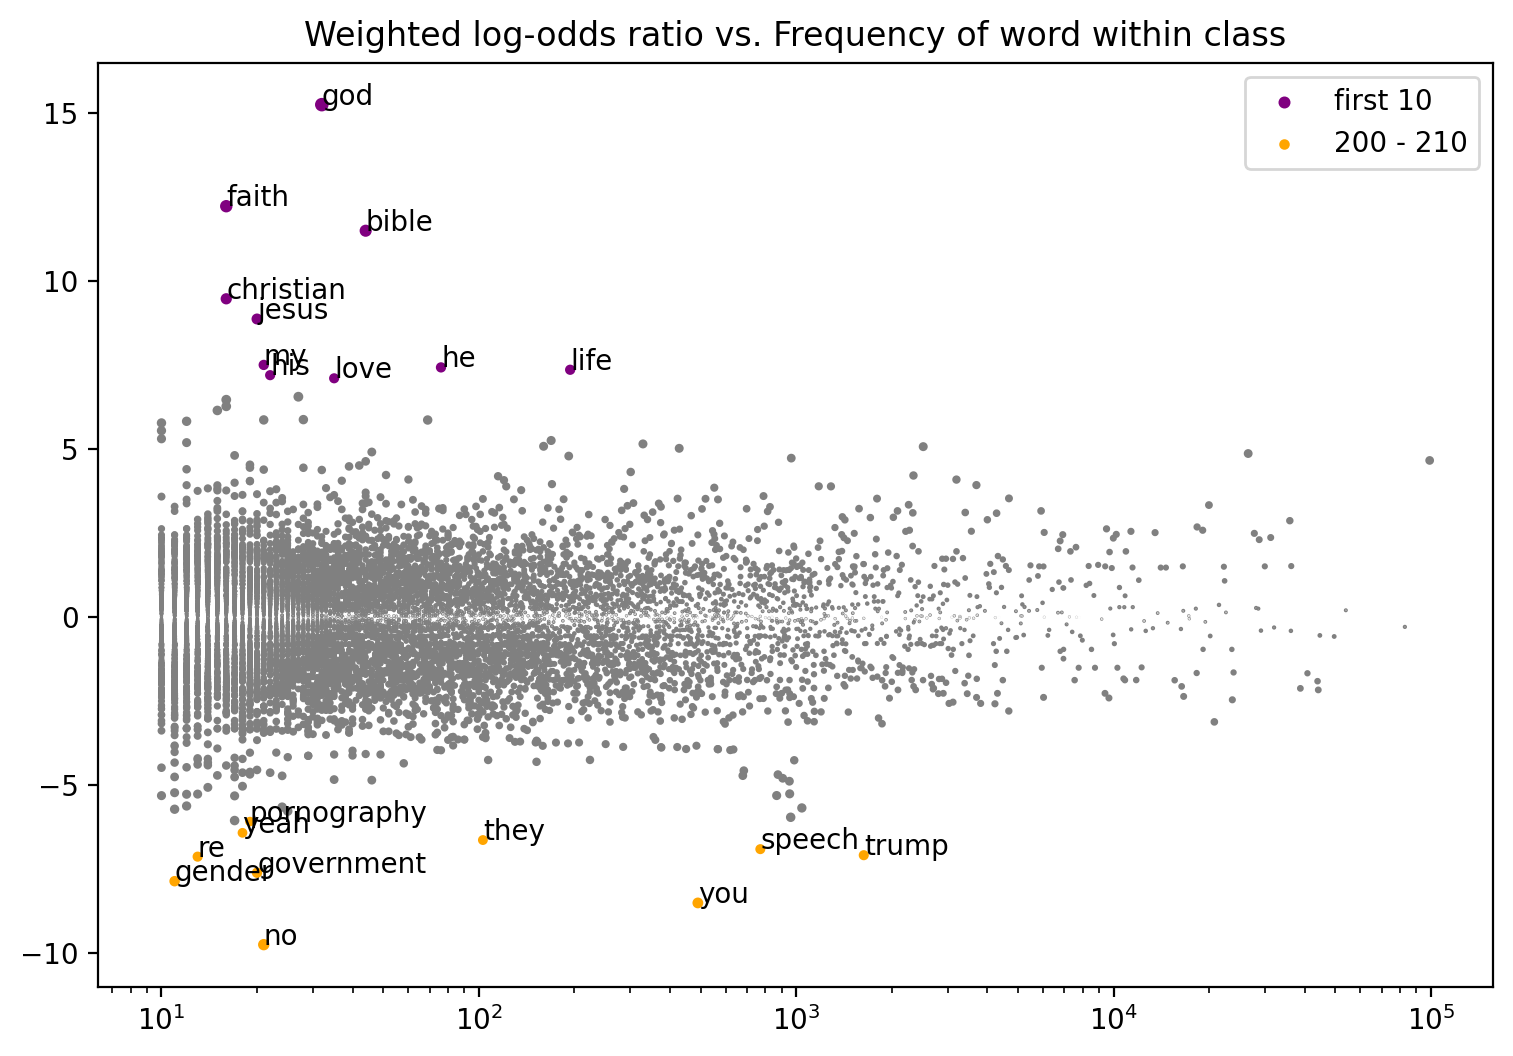

TrueChristian
Initializing default CountVectorizer with ngram_range (1, 1)... Done.
class1_func returned 3630 valid corpus components. class2_func returned 3630 valid corpus components.
Vocab size is 3634
Comparing language...
ngram zscores computed.


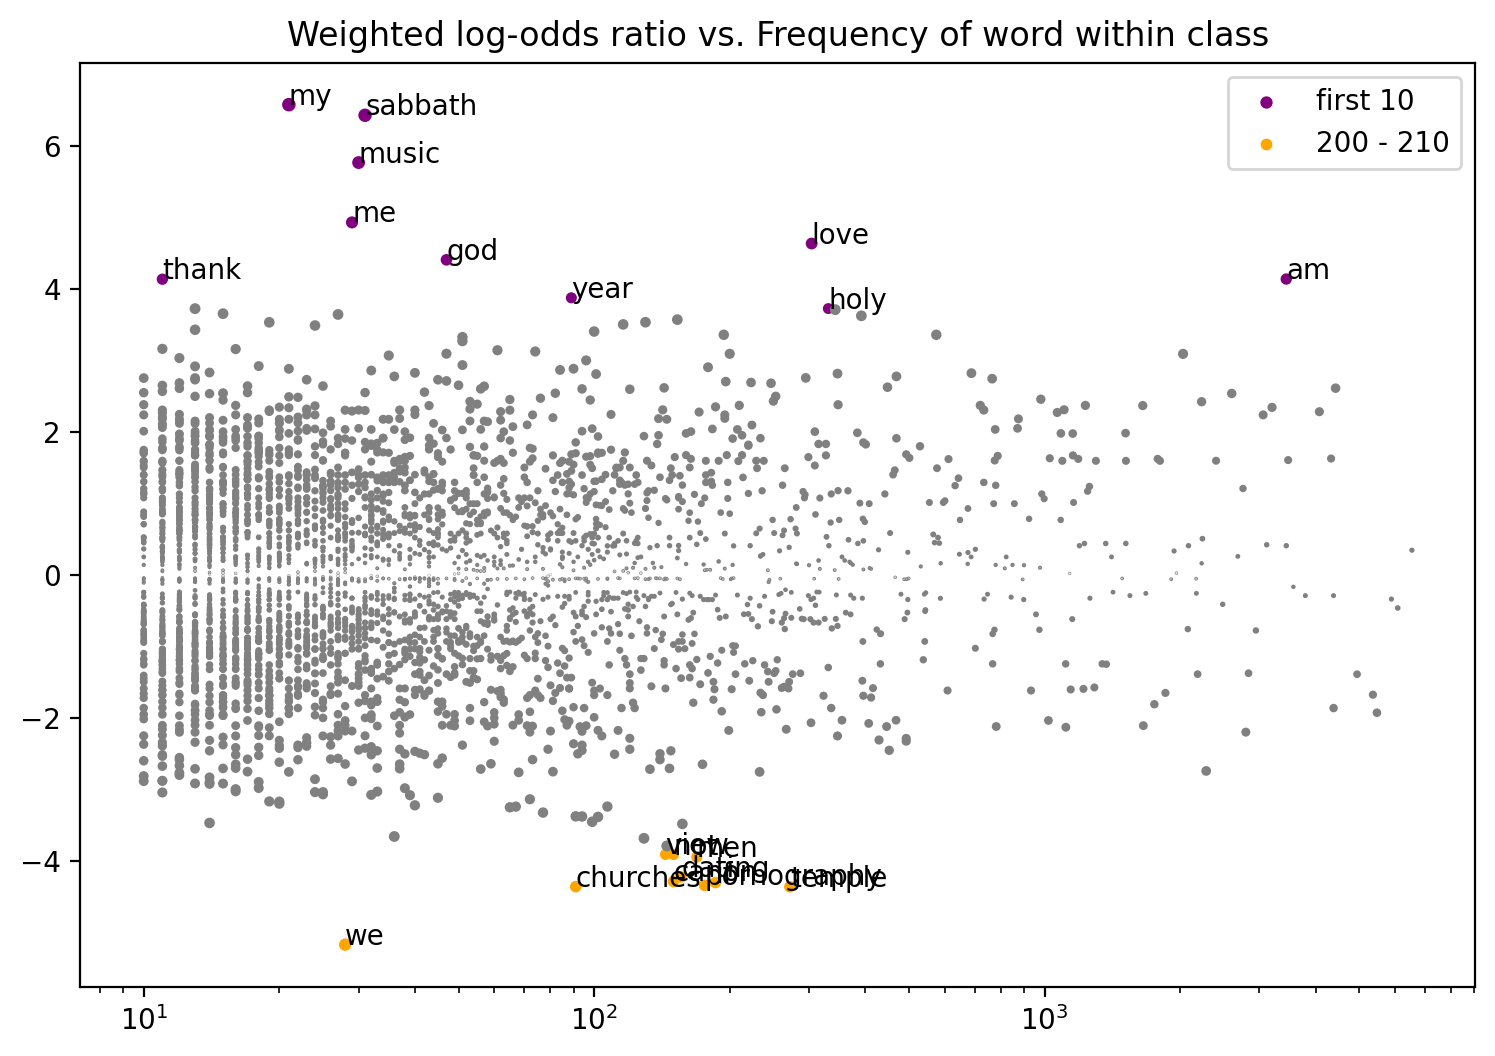

Judaism
Initializing default CountVectorizer with ngram_range (1, 1)... Done.
class1_func returned 3870 valid corpus components. class2_func returned 3870 valid corpus components.
Vocab size is 3192
Comparing language...
ngram zscores computed.


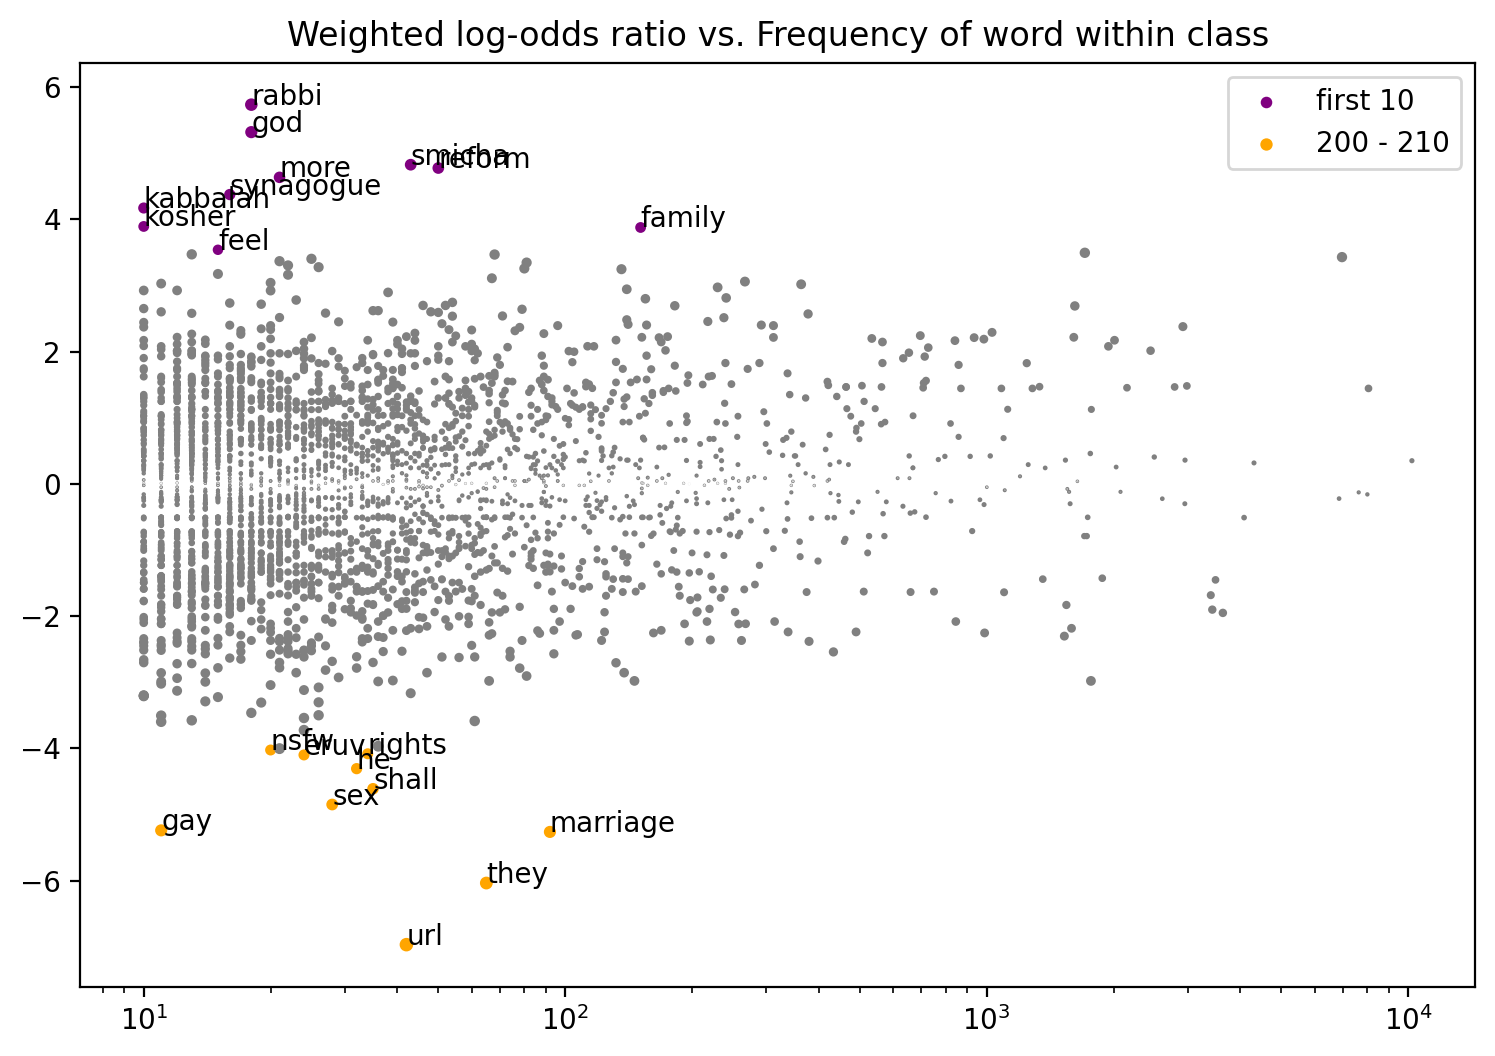

exchristian
Initializing default CountVectorizer with ngram_range (1, 1)... Done.
class1_func returned 3110 valid corpus components. class2_func returned 3110 valid corpus components.
Vocab size is 3129
Comparing language...
ngram zscores computed.


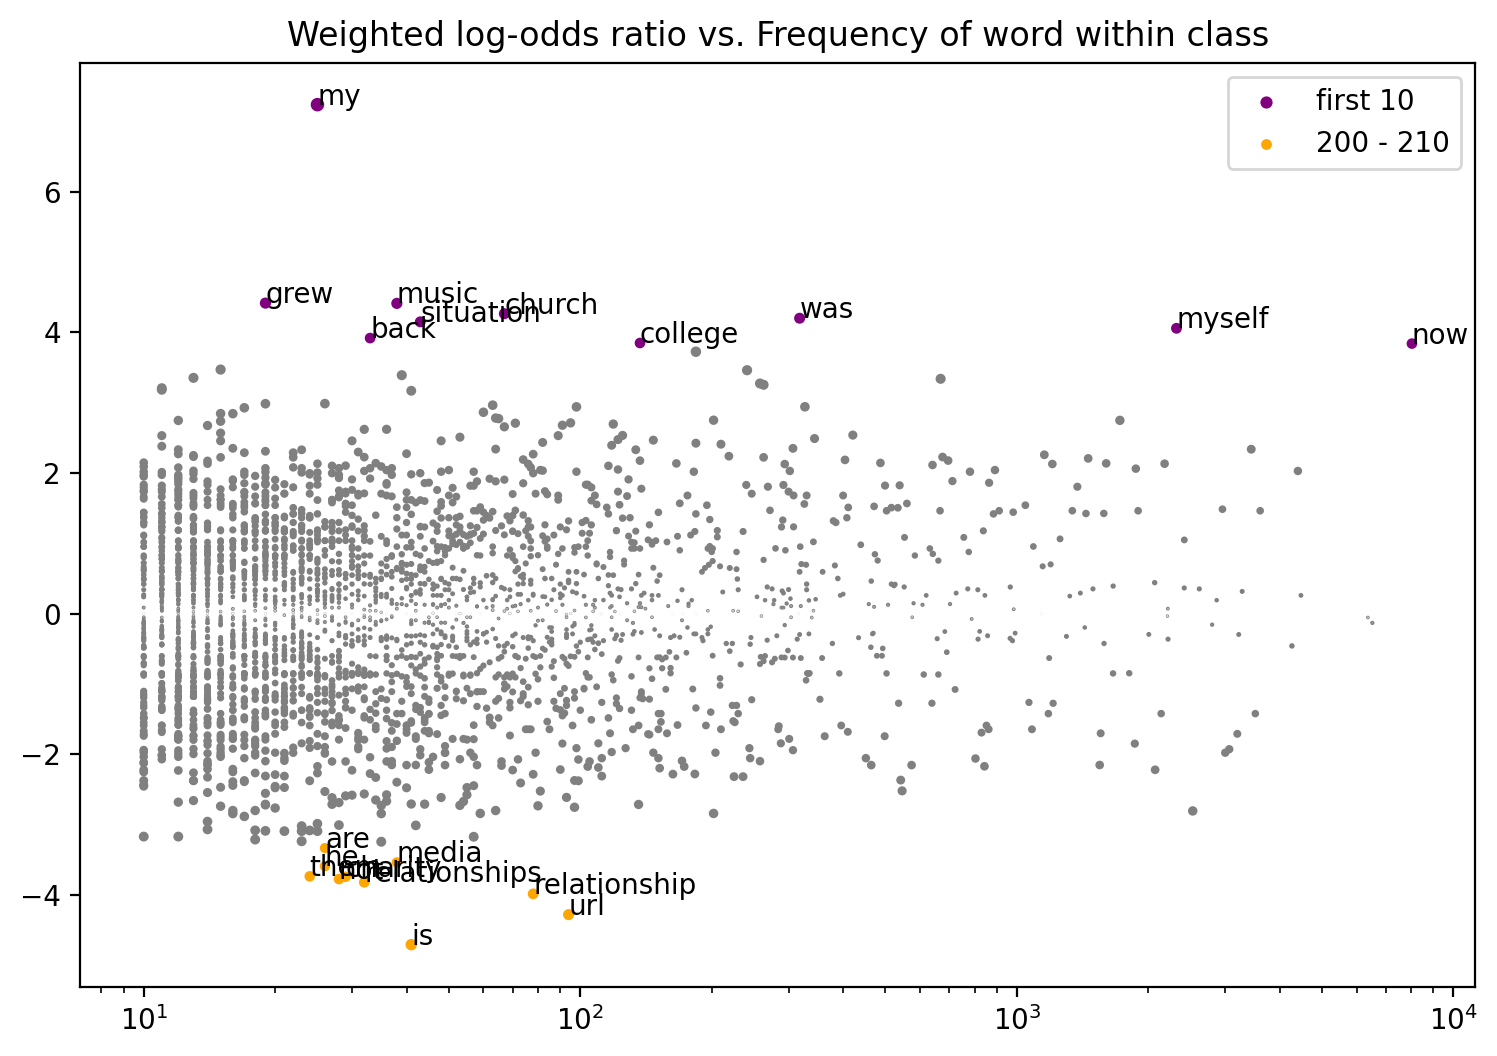

Catholicism
Initializing default CountVectorizer with ngram_range (1, 1)... Done.
class1_func returned 11420 valid corpus components. class2_func returned 11420 valid corpus components.
Vocab size is 7418
Comparing language...
ngram zscores computed.


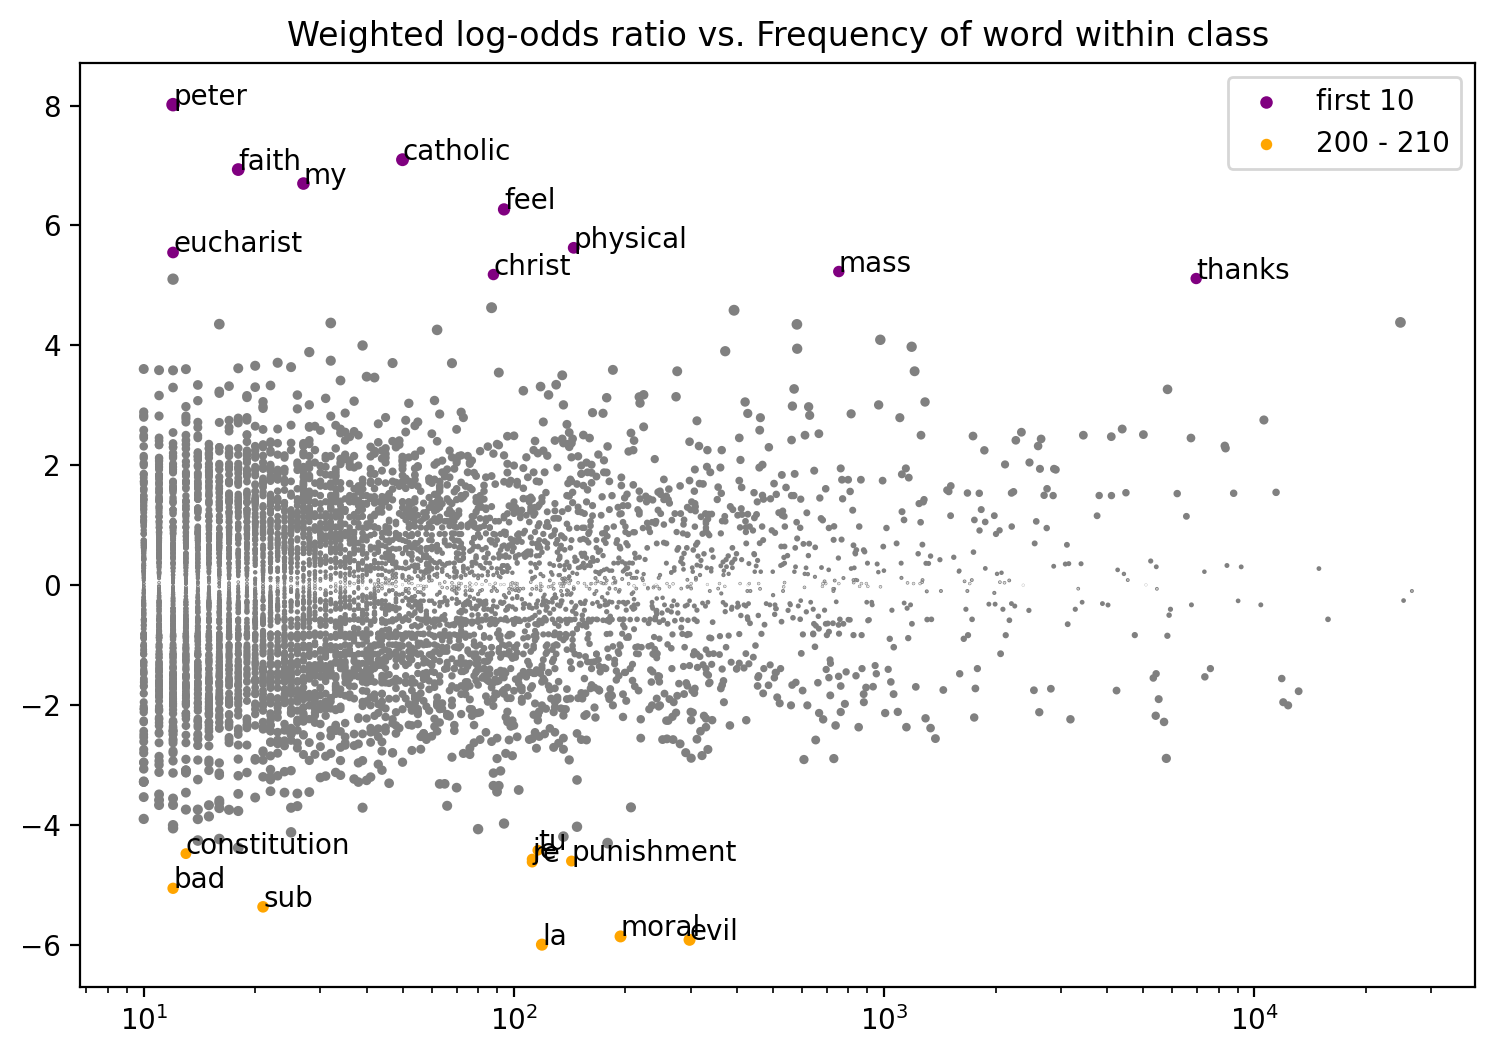

In [447]:
from convokit import Corpus, Speaker, Utterance, FightingWords
fw_dfs = dict()
for subreddit in SUBREDDITS:
    print(subreddit)
    df = comments[subreddit]
    speaker_total_comments = df.groupby("speaker")['order'].max().reset_index(name="n_comments")
    senior_speakers = speaker_total_comments[speaker_total_comments['n_comments'] >= 210]['speaker'].values
    corpus_speakers = {k: Speaker(id = k, meta = {}) for k in senior_speakers}
    utterances = df[df['speaker'].isin(senior_speakers)].reset_index()
    utterance_corpus = {}

    for index, utterance in utterances.iterrows():
        utterance_corpus[index] = Utterance(id = utterance['id'], 
                                            speaker = corpus_speakers[utterance["speaker"]], 
                                            text = str(utterance["text"]), 
                                            meta = {"order": utterance['order']})
    corpus = Corpus(utterances = utterance_corpus.values())
    

    fw = FightingWords(ngram_range=(1,1))
    fw.fit(corpus, class1_func=lambda utt: utt.meta['order'] <= 10, 
                   class2_func=lambda utt: (utt.meta['order'] > 200) and (utt.meta['order'] <= 210))
    
    fw_dfs[subreddit] = fw.summarize(corpus, plot = True, class1_name='first 10', class2_name='200 - 210')

In [450]:
fw_dfs['Buddhism'].sort_values("z-score")[:20]

,z-score,class
ngram,,
url,-6.948401,200 - 210
dhamma,-4.695966,200 - 210
jhana,-4.446046,200 - 210
people,-4.262164,200 - 210
involved,-4.042144,200 - 210
pali,-3.975321,200 - 210
kamma,-3.874887,200 - 210
they,-3.847283,200 - 210
suttas,-3.834153,200 - 210


## Other Explorations

### # of comments in first month statistics (percentile)

In [284]:
subreddit = "Catholicism"
st = speaker_comments_stats[subreddit]
for perc in [50, 60, 70, 80, 90]:
    print(np.percentile(st['n_comments_this_month'], perc))

2.0
4.0
5.0
9.0
21.0


In [254]:
for subreddit in [    
    'TrueChristian', 
    'Buddhism', 
    'Judaism',
    'Christianity'
]:
    print(subreddit)
    st = speaker_comments_stats[subreddit]
    n_comments_first_month = st[(st['n_comments_before_month'] == 0) 
                            & (st['year-month'].str.startswith("2018") | st['year-month'].str.startswith("2017") | st['year-month'].str.startswith("2016"))
                           ]['n_comments_this_month'].values
    for perc in [50, 60, 70, 80, 90]:
        print(perc, np.percentile(n_comments_first_month, perc))
        

TrueChristian
50 2.0
60 2.0
70 3.0
80 5.0
90 9.0
Buddhism
50 1.0
60 2.0
70 2.0
80 3.0
90 6.0
Judaism
50 1.0
60 2.0
70 3.0
80 4.0
90 7.0
Christianity
50 2.0
60 2.0
70 3.0
80 5.0
90 11.0


In [ ]:
# for each month, how many people have 

In [88]:
for subreddit in [
    'TrueChristian', 
    'Buddhism', 
    'Judaism',
    'Christianity',
]:
    print(subreddit)
    print(comments[subreddit].groupby(['year-month']).size().describe())

TrueChristian
count       78.000000
mean      5778.589744
std       3594.132077
min          3.000000
25%       3209.250000
50%       5800.000000
75%       7792.250000
max      15350.000000
dtype: float64
Buddhism
count      128.00000
mean      5623.37500
std       3942.61909
min          1.00000
25%       1016.75000
50%       6331.00000
75%       8882.50000
max      12793.00000
dtype: float64
Judaism
count      118.000000
mean      5237.923729
std       3803.134778
min          1.000000
25%        893.000000
50%       6139.500000
75%       8113.750000
max      13619.000000
dtype: float64
Christianity
count      129.000000
mean     43064.775194
std      28667.915580
min          3.000000
25%       8292.000000
50%      53429.000000
75%      65948.000000
max      92620.000000
dtype: float64


In [78]:
for subreddit in [
    'TrueChristian', 
    'Buddhism', 
    'Judaism',
    'Christianity',
]:
    print(subreddit)
    print(comments[subreddit].groupby(['speaker']).size().describe())

TrueChristian
count    18831.000000
mean        23.935532
std        135.239374
min          1.000000
25%          1.000000
50%          3.000000
75%         10.000000
max       5725.000000
dtype: float64
Buddhism
count    45380.000000
mean        15.861437
std        148.120739
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max      11792.000000
dtype: float64
Judaism
count    18400.000000
mean        33.591033
std        336.623290
min          1.000000
25%          1.000000
50%          3.000000
75%          8.000000
max      25213.000000
dtype: float64
Christianity
count    161397.000000
mean         34.420442
std         323.918340
min           1.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       27487.000000
dtype: float64


In [54]:
# s = newcomer_ratio['TrueChristian']
# for subreddit in [
#     'Buddhism', 
#     'Judaism',
#     'Christianity',
# ]:
#     s = s.join(newcomer_ratio[subreddit], how='outer')
#     s.to_csv("speaker_stats.csv")

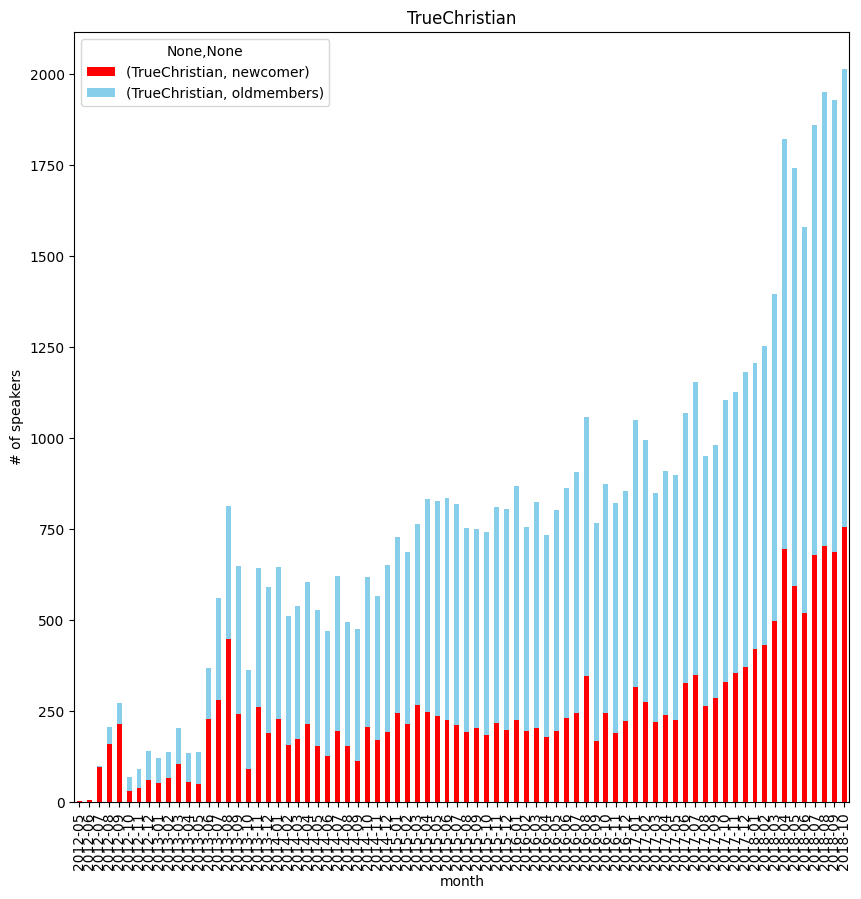

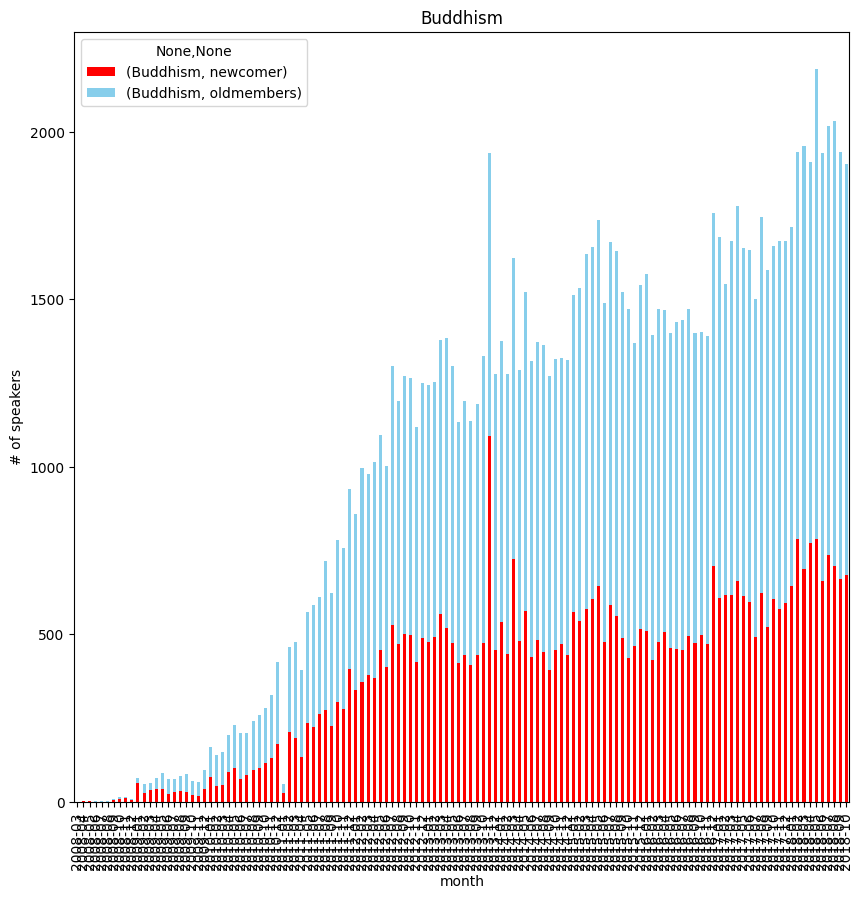

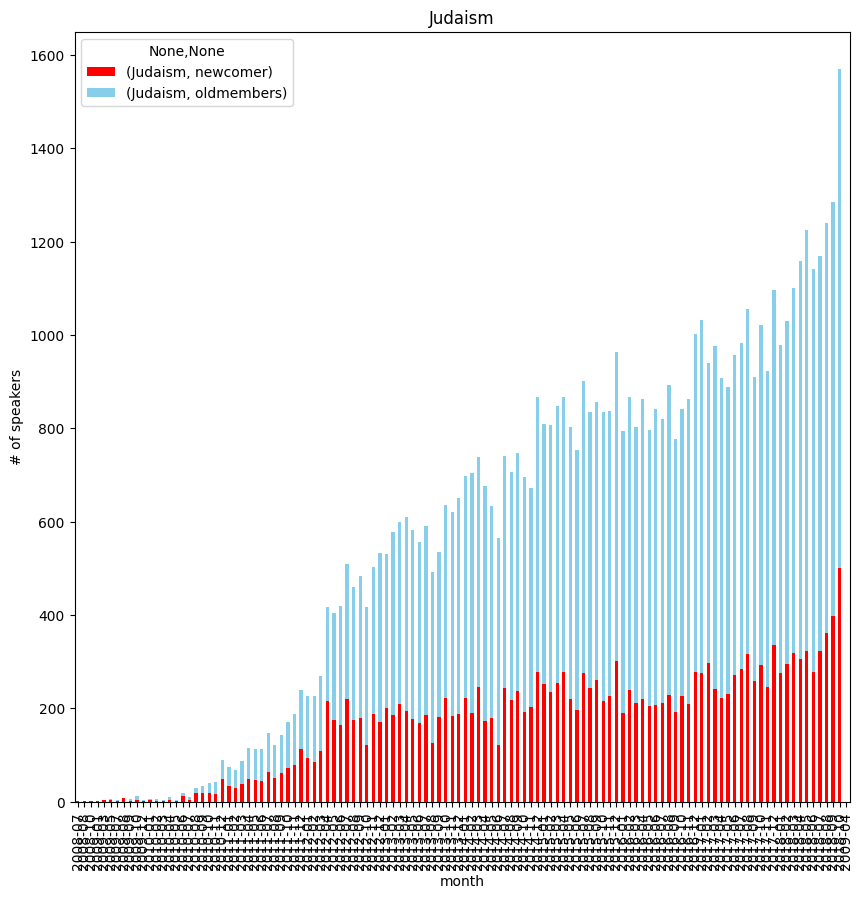

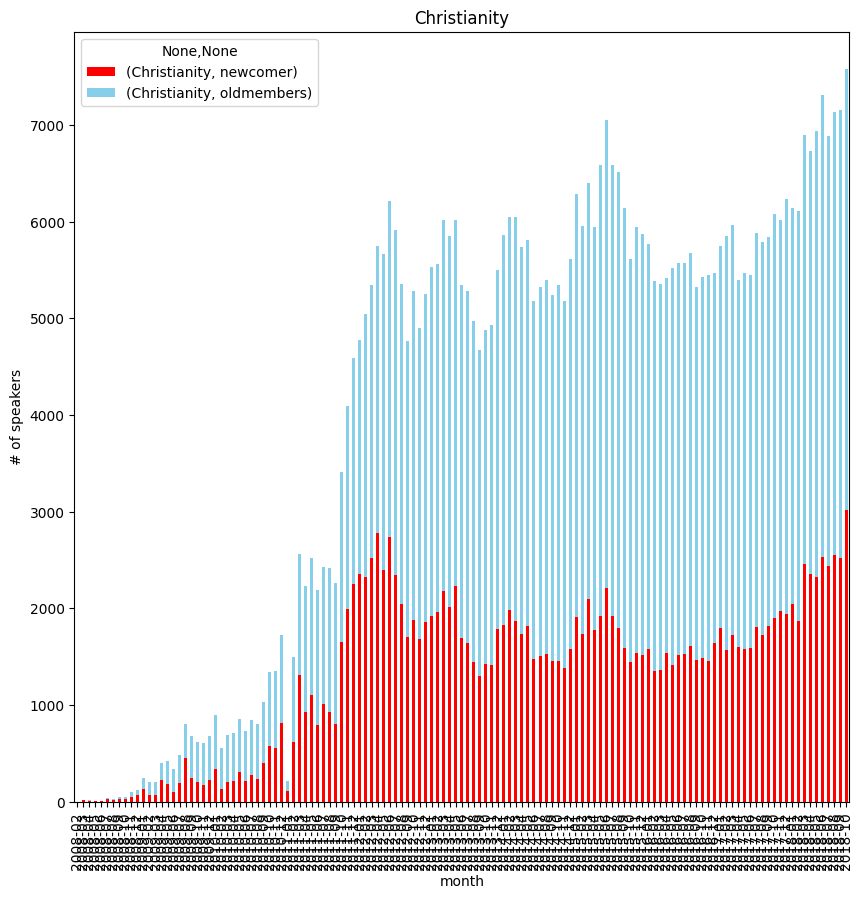

In [59]:
for subreddit in [
    'TrueChristian', 
    'Buddhism', 
    'Judaism',
    'Christianity',
]:
    s = newcomer_ratio[subreddit]
    s[[(subreddit,'newcomer'), (subreddit, 'oldmembers')]].plot(kind='bar', stacked=True, color=['red', 'skyblue'], figsize=(10,10))
    plt.ylabel("# of speakers")
    plt.xlabel("month")
    plt.title(subreddit)

In [301]:
for subreddit in [
    'Christianity',
#     'TrueChristian', 
#     'Buddhism', 
#     'Judaism'
]:
    df = pd.read_json(f"{subreddit}_utterances.json")
    
    first_post = df.groupby(['speaker'])['timestamp'].min()
    first_post = first_post.reset_index()
    first_post['year'] = first_post['timestamp'].dt.year
    newcomer_first_utt = pd.DataFrame()
    ref_utt = json.load(open(f"./{subreddit}_ref_utt.json", "r"))
    for year in YEARS:
        speakers_joined_this_year = first_post[first_post['year'] == year]["speaker"].values
        year_newcomer_utt = df[(df['meta.year'] == year) & (df['speaker'].isin(speakers_joined_this_year))]
        year_newcomer_first_utt = year_newcomer_utt.sort_values(['speaker', 'timestamp']).drop_duplicates("speaker", keep='first')
        print(len(year_newcomer_first_utt))
        year_newcomer_first_utt = year_newcomer_first_utt[~year_newcomer_first_utt.index.isin(ref_utt[str(year)])]
        print(len(year_newcomer_first_utt))
        newcomer_first_utt = pd.concat([newcomer_first_utt, year_newcomer_first_utt])
    
    
    newcomer_year_cross_entropy = gt_cross_entropy(newcomer_first_utt, ref_utt, N=2)
    pk.dump(newcomer_year_cross_entropy, open(f"newcomer_cross_entropy_{subreddit}.pk", "wb"))
    

26627
26410
21011
20801
19625
19467
21452
21267
17966
17806
21044
20880
24115
23934
dfris8k []
doxuf4x []
dmryz0l []
dnph1kn []
e5y1vup []


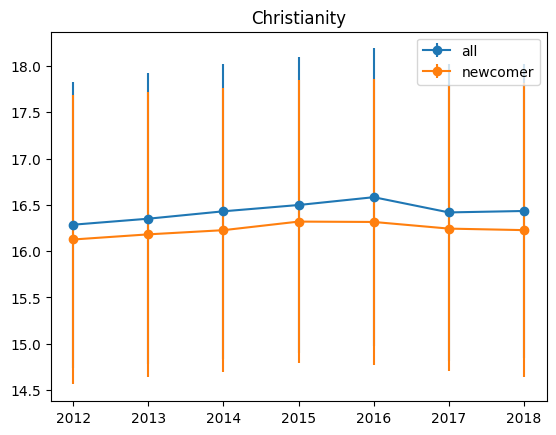

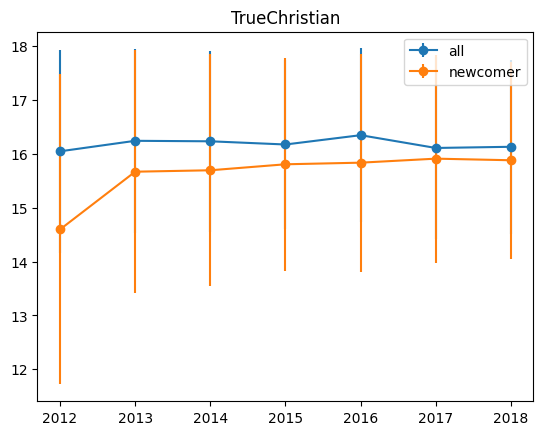

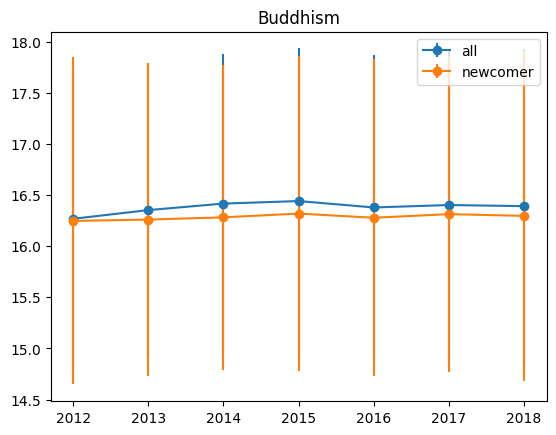

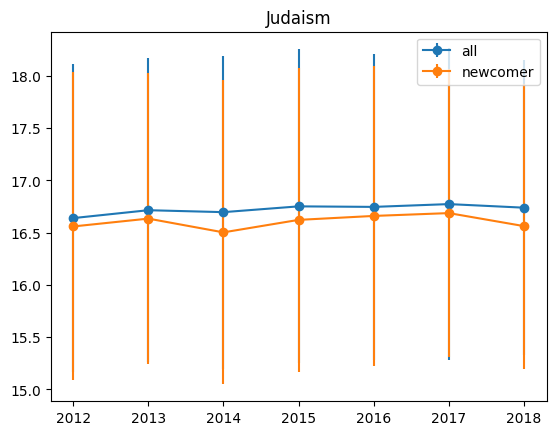

In [302]:
for subreddit in ['Christianity', 'TrueChristian', 'Buddhism', 'Judaism']:
    # all
    year_cross_entropy = pk.load(open(f"./ce-by-year-{subreddit}.pk", "rb"))

    mean_ce = [np.mean(year_cross_entropy[year]) for year in YEARS]
    std_ce = [np.std(year_cross_entropy[year]) for year in YEARS]

    plt.errorbar(YEARS, mean_ce, yerr=std_ce, fmt="o-", label='all')

    # newcomer
    newcomer_year_cross_entropy = pk.load(open(f"newcomer_cross_entropy_{subreddit}.pk", "rb"))
    newcomer_mean_ce = [np.mean(newcomer_year_cross_entropy[year]) for year in YEARS]
    newcomer_std_ce = [np.std(newcomer_year_cross_entropy[year]) for year in YEARS]

    plt.errorbar(YEARS, newcomer_mean_ce, yerr=newcomer_std_ce, fmt="o-", label='newcomer')
    plt.legend()
    plt.title(subreddit)
    plt.show()

In [ ]:
# dfris8k, doxuf4x, dmryz0l, dnph1kn, e5y1vup
line = strip_punctuation(df.loc['dfris8k']['text'])
print(line)
words = tokenize_words(line, filter_stopwords=False)
print(words)